## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

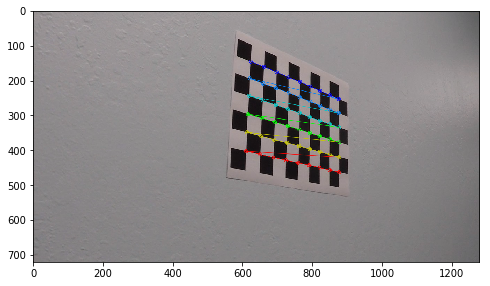

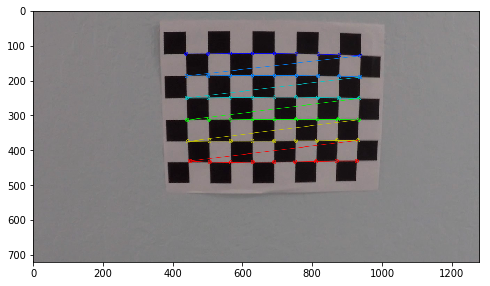

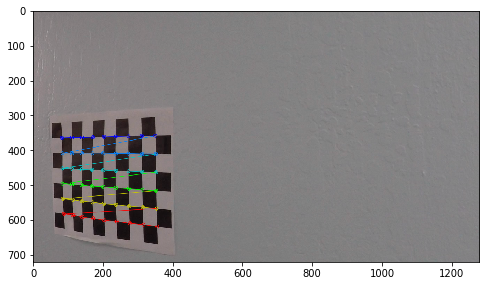

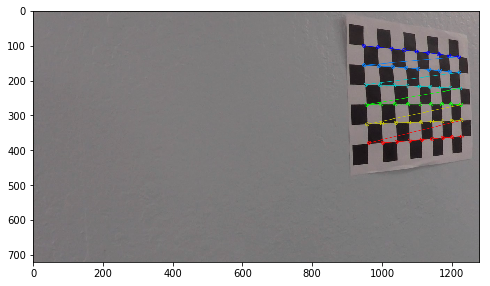

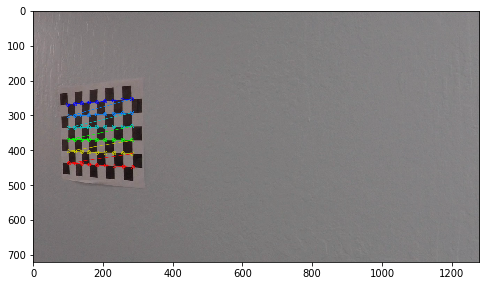

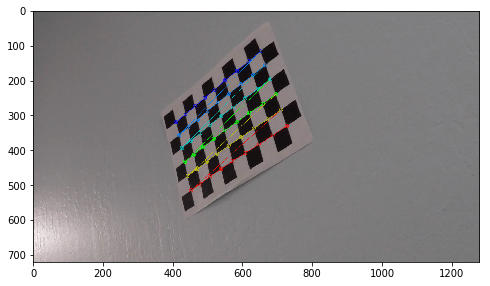

In [ ]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)#build a matrix of 54*3
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)#T means transpose，:2 means the first two columns

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.figure(figsize = (8,8))
        plt.imshow(img)       

## And so on and so forth...

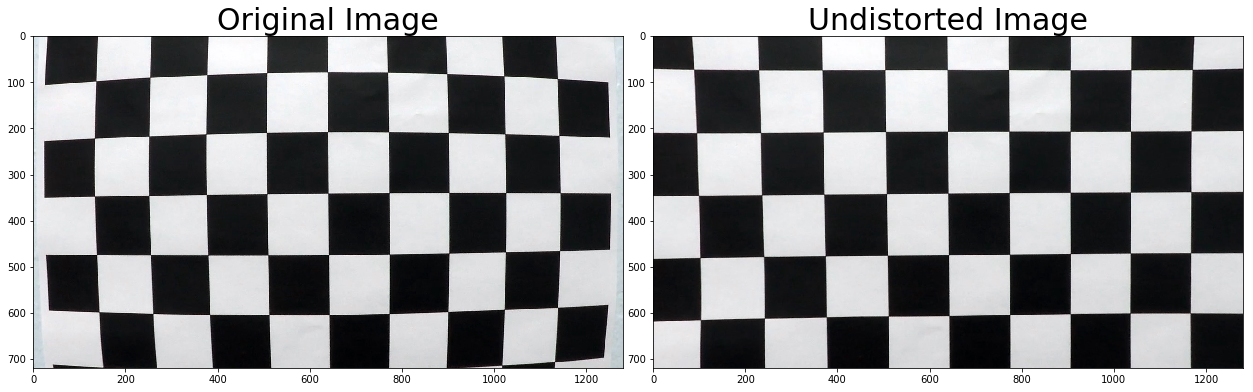

In [2]:
#do the camera calibration, image distortion correction 
#and have a test of a chessboard image

def undistort(img):#performs the image distortion correction and returns the undistorted image
    cal_pickle = pickle.load(open("../camera_cal/wide_dist_pickle.p", "rb"))
    mtx = cal_pickle['mtx']
    dist = cal_pickle['dist']
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    return undist

image = cv2.imread('../camera_cal/calibration1.jpg')
img_size = (image.shape[1],image.shape[0])
# Calibrate camera and save the result, ignoring rvecs / tvecs
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "../camera_cal/wide_dist_pickle.p", "wb" ) )

#a test of a chessboard image
img_test0=image
img_undist0 = undistort(img_test0)
 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))# f indicating the whole plot picture
f.tight_layout()#adjustint the edge
ax1.imshow(img_test0)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undist0)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0.5, right=1.2, top=0.9, bottom=0.) #adjusting the gap

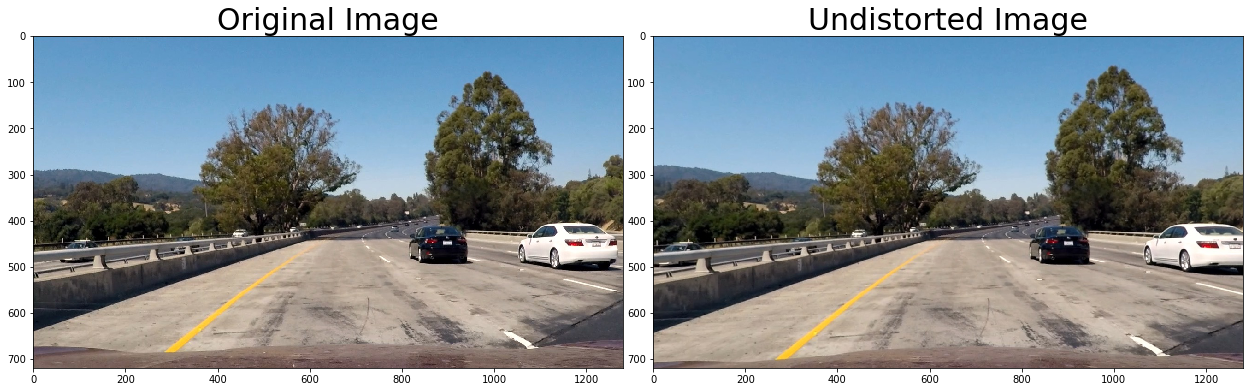

In [3]:
#the undistorting test of a picture in the realworld
img_test1 = mpimg.imread( '../test_images/test1.jpg')
img_undist1 = undistort(img_test1)
 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_test1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undist1)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0.5, right=1.2, top=0.9, bottom=0.)

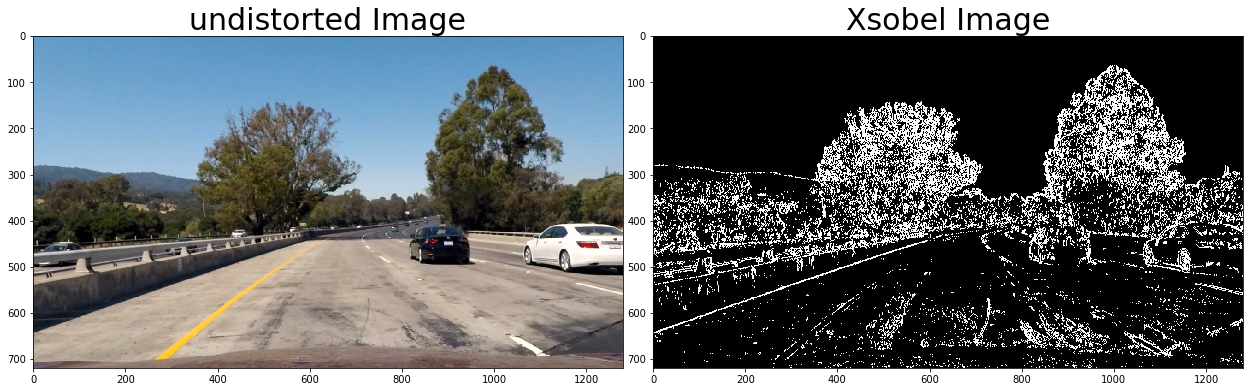

In [32]:
#the functions to apply Sobel x or y, then take an absolute value and apply a threshold. 
def sobel_XY(img,sobel_kernelsize = 3):#the img need to be gray image
    sobel=[0,0]
    sobelx=cv2.Sobel(img,cv2.CV_64F,1,0,ksize = sobel_kernelsize)
    sobely=cv2.Sobel(img,cv2.CV_64F,0,1,ksize = sobel_kernelsize)
    sobel[0]=sobelx
    sobel[1]=sobely    
    return sobel

#the functions to take an absolute value of the Sobel x or y, then and apply a threshold. 
def abs_sobel_thresh(sobel,orient = 'x',thresh_min=0, thresh_max=255):
    if orient == 'x':
        abs_sobel = np.absolute(sobel[0])
    if orient == 'y':
        abs_sobel = np.absolute(sobel[1])
    
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

#the test of sobel process
gray = cv2.cvtColor(img_undist1, cv2.COLOR_RGB2GRAY)
sobel=sobel_XY(gray)
img_Xsobel=abs_sobel_thresh(sobel, thresh_min=10, thresh_max=100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_undist1)
ax1.set_title('undistorted Image', fontsize=30)
ax2.imshow(img_Xsobel,cmap = 'gray')
ax2.set_title('Xsobel Image', fontsize=30)
plt.subplots_adjust(left=0.5, right=1.2, top=0.9, bottom=0.)

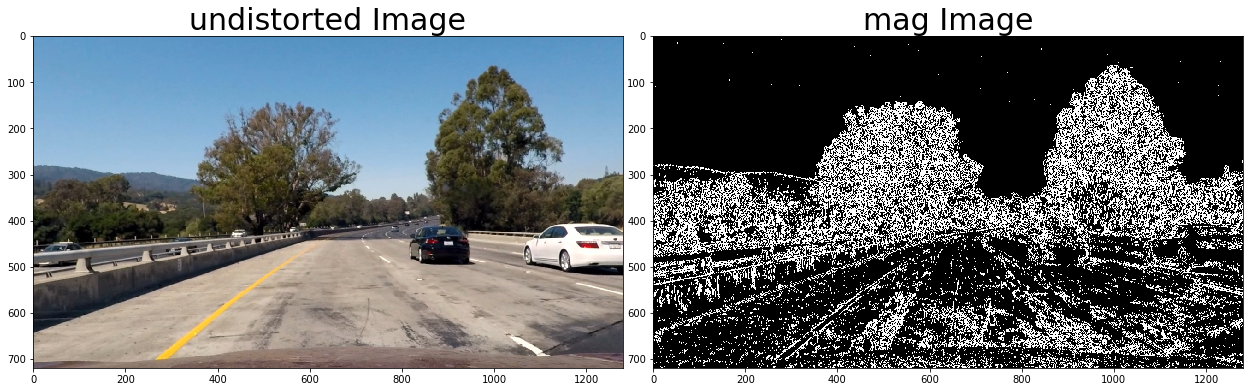

In [18]:
#the functions to compute the magnitude of the gradient and applies a threshold
def mag_thresh(sobel, thresh_min=0, thresh_max=255):#the img need to be gray image
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobel[0]**2 + sobel[1]**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output

#the test of sobelmagnitude process
gray = cv2.cvtColor(img_undist1, cv2.COLOR_RGB2GRAY)
sobel=sobel_XY(gray)
img_mag=abs_sobel_thresh(sobel, thresh_min=5, thresh_max=30)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_undist1)
ax1.set_title('undistorted Image', fontsize=30)
ax2.imshow(img_mag,cmap = 'gray')
ax2.set_title('mag Image', fontsize=30)
plt.subplots_adjust(left=0.5, right=1.2, top=0.9, bottom=0.)

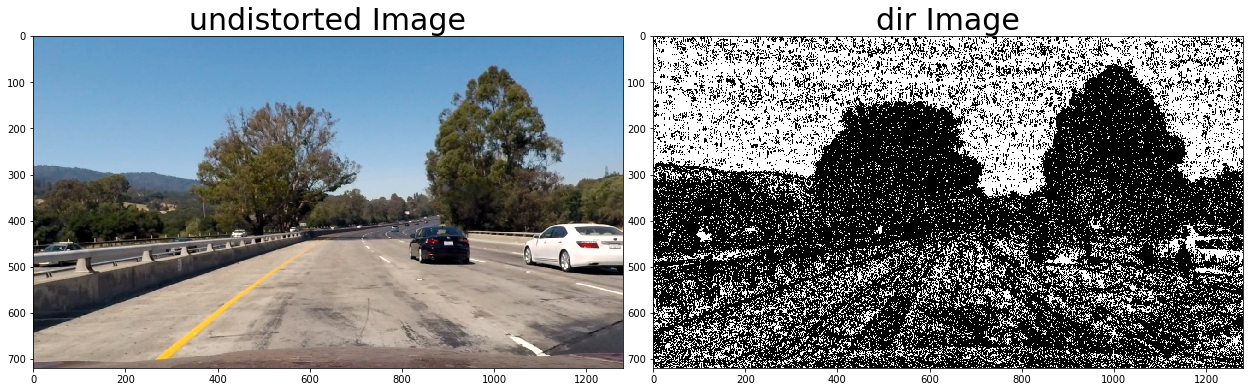

In [25]:
# the function to compute the direction of the gradient and apply a threshold.
def dir_threshold(sobel, thresh_min=10, thresh_max=np.pi/2):
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobel[1]), np.absolute(sobel[1]))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

#the test of sobel direction process
gray = cv2.cvtColor(img_undist1, cv2.COLOR_RGB2GRAY)
sobel=sobel_XY(gray)
img_dir=abs_sobel_thresh(sobel, thresh_min=0, thresh_max=np.pi/6)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_undist1)
ax1.set_title('undistorted Image', fontsize=30)
ax2.imshow(img_dir,cmap = 'gray')
ax2.set_title('dir Image', fontsize=30)
plt.subplots_adjust(left=0.5, right=1.2, top=0.9, bottom=0.)

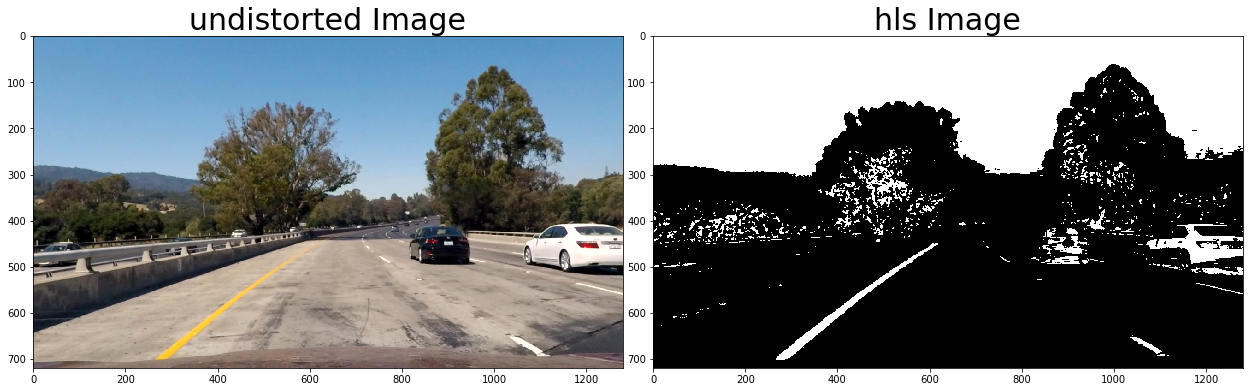

In [7]:
# the function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh_min=0, thresh_max=255):
   
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh_min) & (s_channel <= thresh_max)] = 1
    return binary_output

#the test of sobel direction process
img_hls=hls_select(img_undist1, thresh_min=110, thresh_max=255)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_undist1)
ax1.set_title('undistorted Image', fontsize=30)
ax2.imshow(img_hls,cmap = 'gray')
ax2.set_title('hls Image', fontsize=30)
plt.subplots_adjust(left=0.5, right=1.2, top=0.9, bottom=0.)

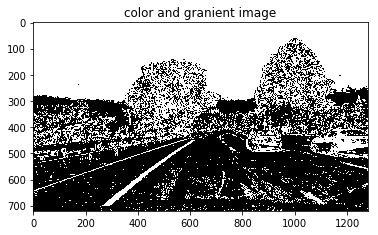

In [34]:
color_x_sobel = np.zeros_like(img_Xsobel)
color_x_sobel[ (img_hls== 1) | (img_Xsobel) == 1 ] = 1
plt.imshow(color_x_sobel,cmap = 'gray')
plt.title('color and granient image')
plt.show()


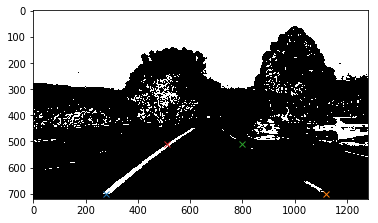

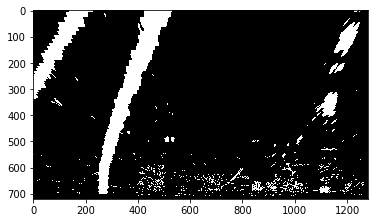

In [35]:
#warp the image to a top-down view
def warp2TD(img):
    img_size = (img.shape[1],img.shape[0])
    
    src = np.float32( [ [280,700],[1120,700],[800,510],[510,510]] )
    dst = np.float32( [ [270,700],[1110,700],[1110,480],[270,480]] )
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img,M,img_size,flags = cv2.INTER_LINEAR)
    
    return warped, M,Minv

#a test of warping the image to a top-down view
plt.imshow(img_hls,cmap = 'gray')
plt.plot(280,700,'x')
plt.plot(1120,700,'x')
plt.plot(800,510,'x')
plt.plot(510,510,'x')
plt.show()

top_down, perspective_M,perspective_Minv = warp2TD(color_x_sobel) 
plt.imshow(top_down,cmap = 'gray')
plt.show()

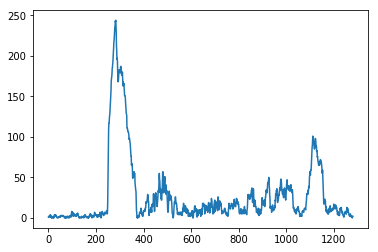

In [36]:
#Create histogram of image
def hist(img):
    bottom_half = None
    bottom_half = img[img.shape[0]//2:,:]
    histogram = None
    histogram = np.sum(bottom_half, axis=0)#axis=0 indicate the sum of the column
    
    return histogram

# the test of histogram
histogram = hist(top_down)
plt.plot(histogram) 


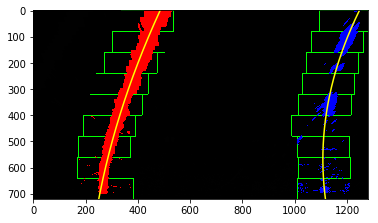

In [12]:
#find the pixels of the lane,almost the same as the quiz
def find_lane_pixels(binary_warped):
    histogram = hist(binary_warped)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

#the function to calculate the line of the lane
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img,left_fit,right_fit

out_img,left_fit,right_fit = fit_polynomial(top_down)
plt.imshow(out_img)

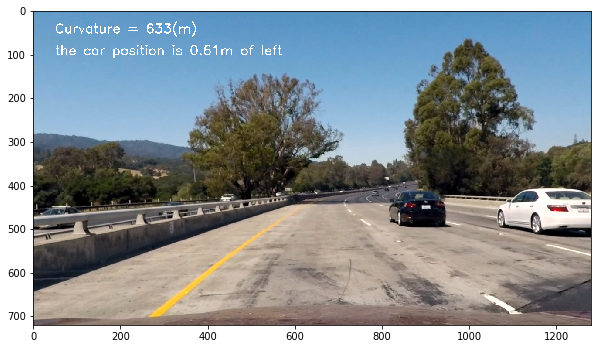

In [39]:
#Calculates the curvature of polynomial functions in pixels and car position.
def measure_curvature_pos(binary_warped,left_fit,right_fit):
 
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0,binary_warped.shape[0] -1 , binary_warped.shape[0])
    y_eval = np.max(ploty)
    ym_per_pix = 30/720  #meter/pixel in y
    xm_per_pix = 3.7/700 #meter/pixel in x
    
    #calculate the position of the car=the center of the lane
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[1]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[1]*y_eval + right_fit[2]
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    #640 is the mid of 1280 which is the number of the pixels of x, and car position is the offset to the image center
    car_pos = (lane_center-640)*xm_per_pix   
    
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #change to meter
    left_fit_M = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_M = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_M[0]*y_eval*ym_per_pix + left_fit_M[1])**2)**1.5) / np.absolute(2*left_fit_M[0])
    right_curverad = ((1 + (2*right_fit_M[0]*y_eval*ym_per_pix + right_fit_M[1])**2)**1.5) / np.absolute(2*right_fit_M[0])
    
    return left_curverad,right_curverad,car_pos

#show the parrameters in the image 
def show_par(img,left_cur,right_cur,car_pos):
    cur = (left_cur + right_cur) / 2.    
    cv2.putText(img,'Curvature = %d(m)' % cur,(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
       
    if car_pos < 0:
        direction = 'left'
    else:
        direction = 'right'
        
    cv2.putText(img,'the car position is %.2fm of %s'%(np.abs(car_pos),direction),(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad,car_position = measure_curvature_pos(top_down,left_fit,right_fit)
#print(car_position)
show_par(img_undist1,left_curverad,right_curverad,car_position)
plt.figure(figsize = (10,10))
plt.imshow(img_undist1)
plt.show()

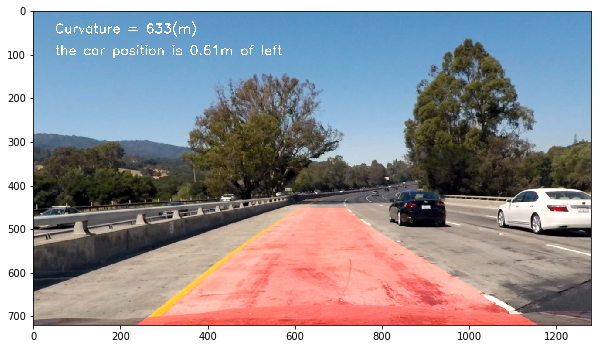

In [40]:
#show the lane poly in the original image
def show_poly(img_undist,top_down,M,left_fit,right_fit,left_curverad,right_curverad,car_pos):
    img_zero = np.zeros_like(top_down).astype(np.uint8)
    color_img = np.dstack((img_zero,img_zero,img_zero))
    
    ploty = np.linspace(0,img_zero.shape[0]-1,img_zero.shape[0])
    left_fitx = left_fit[0] * ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #the points of the left lane from top to down
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    ##the points of the right lane from top to down
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    #the points form the polygon。
    pts = np.hstack((pts_left, pts_right))
    #fill the polygon.
    cv2.fillPoly(color_img, np.int_([pts]), (255,0, 0))
    #translate back to the original
    #M=M.I
    img_org = cv2.warpPerspective(color_img, M, (color_img.shape[1], color_img.shape[0])) 
    newimg = cv2.addWeighted(img_undist, 1, img_org, 0.5, 0)
    show_par(newimg, left_curverad,right_curverad,car_pos)
          
    return newimg
img_poly=show_poly(img_undist1,top_down,perspective_Minv,left_fit,right_fit,left_curverad,right_curverad,car_position)
plt.figure(figsize = (10,10))
plt.imshow(img_poly)
plt.show()

In [41]:
#sometimes the line can not be detected correctly
def diagnose(left_fit, right_fit):
     
    # Check if left and right fit returned a value
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False        
    else:
        #Check distance of the two lines
        ploty = np.linspace(0, 20, num=10 )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        delta_lines = np.mean(right_fitx - left_fitx)
        if delta_lines >= 290 and delta_lines <=840: #apprrox gap in pixels of two lines accoiding the parameters of perspective transmition
            status = True
        else:
            status = False
    return status

prev_left_fit=[0,0,0]
prev_right_fit=[0,0,0]
def pipeline_image(img):
    #global prev_left 
    #global last_right
    global prev_left_fit
    global prev_right_fit
    
    #undistortion
    img_undist = undistort(img)
    gray = cv2.cvtColor(img_undist, cv2.COLOR_RGB2GRAY)
    sobel=sobel_XY(gray)
    img_Xsobel=abs_sobel_thresh(sobel, thresh_min=10, thresh_max=100)
    #sobel detection
    x_sobel = abs_sobel_thresh(img_undist,thresh_min=5, thresh_max=5)
    #hls filter
    img_hls=hls_select(img_undist, thresh_min=110, thresh_max=255)
    #sobel & hls
    color_x_sobel = np.zeros_like(img_Xsobel)
    color_x_sobel[ (img_hls== 1) | (img_Xsobel) == 1 ] = 1
    
    #perspective transmition
    top_down, perspective_M,perspective_Minv = warp2TD(color_x_sobel) 
        
    #find the left and right line of the lane 
    out_img,left_fit,right_fit = fit_polynomial(top_down)
    
    status = diagnose(left_fit,right_fit)
    
    
    if status == True:
        prev_left_fit , prev_right_fit = left_fit,right_fit
    else:
        left_fit,right_fit =  prev_left_fit , prev_right_fit
   
    #calculate the curvature
    left_curverad, right_curverad,car_position = measure_curvature_pos(top_down,left_fit,right_fit)
    #draw poly
    img_poly=show_poly(img_undist,top_down,perspective_Minv,left_fit,right_fit,left_curverad,right_curverad,car_position)
    
    return img_poly


[MoviePy] >>>> Building video test_video.mp4
[MoviePy] Writing video test_video.mp4


100%|█████████▉| 1260/1261 [05:00<00:00,  4.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video.mp4 

CPU times: user 2min 50s, sys: 9.6 s, total: 3min
Wall time: 5min 3s


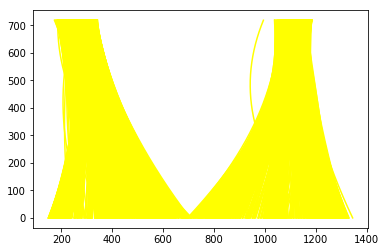

In [42]:
from moviepy.editor import VideoFileClip
output = 'test_video.mp4'
clip1 = VideoFileClip("../project_video.mp4")

out_clip = clip1.fl_image(pipeline_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)


In [43]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))